In [1]:
from brian2 import *

import plot_utils as pu

set_device('cpp_standalone', directory=None)  # Use fast "C++ standalone mode"
seed(790824)  # to get identical figures for repeated runs

# Parameters required

In [2]:
### General parameters
duration = 30*second          # Total simulation time
sim_dt = 1*ms                 # Integrator/sampling step

### Neuron parameters
f_0 = 0.5*Hz                  # Spike rate of the "source" neurons

### Synapse parameters
rho_c = 0.001                 # Synaptic vesicle-to-extracellular space volume ratio
Y_T = 500*mmolar              # Total vesicular neurotransmitter concentration
Omega_c = 40/second           # Neurotransmitter clearance rate

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second       # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.1 * umolar            # Ca2+ affinity of SERCAs
C_T = 2*umolar                # Total cell free Ca^2+ content
rho_A = 0.18                  # ER-to-cytoplasm volume ratio
Omega_C = 6/second            # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second          # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar             # IP_3 binding affinity
d_2 = 1.05*umolar             # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second       # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar           # IP_3 dissociation constant
d_5 = 0.08*umolar             # Ca^2+ activation dissociation constant
# --- Agonist-dependent IP_3 production
O_beta = 5*umolar/second      # Maximal rate of IP_3 production by PLCbeta
O_N = 0.3/umolar/second       # Agonist binding rate
Omega_N = 0.5/second          # Maximal inactivation rate
K_KC = 0.5*umolar             # Ca^2+ affinity of PKC
zeta = 10                     # Maximal reduction of receptor affinity by PKC
# --- IP_3 production
O_delta = 0.2 *umolar/second  # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5 * umolar    # Inhibition constant of PLC_delta by IP_3
K_delta = 0.3*umolar          # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.1/second         # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.5*umolar              # Ca^2+ affinity of IP3-3K
K_3K = 1*umolar               # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second      # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 external production
F_ex = 0.09*umolar/second     # Maximal exogenous IP3 flow
I_Theta = 0.3*umolar          # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar         # Scaling factor of diffusion

# Neuron and Synapse 


In [ ]:
defaultclock.dt = sim_dt  # Set the integration time

### "Neurons"
# (We are only interested in the activity of the synapse, so we replace the
# neurons by trivial "dummy" groups
# # Regular spiking neuron
source_neurons = NeuronGroup(1, 'dx/dt = f_0 : 1', threshold='x>1',
                             reset='x=0', method='euler')
## Dummy neuron
target_neurons = NeuronGroup(1, '')

In [ ]:
### Synapses
# Our synapse model is trivial, we are only interested in its neurotransmitter
# release
synapses_eqs = 'dY_S/dt = -Omega_c * Y_S : mmolar (clock-driven)'
synapses_action = 'Y_S += rho_c * Y_T'
synapses = Synapses(source_neurons, target_neurons,
                    model=synapses_eqs, on_pre=synapses_action,
                    method='linear')
synapses.connect()


# Astrocytes

In [5]:
# We modelled both stochastic and deterministic
astro_eqs = '''
# Fraction of activated astrocyte receptors:
dGamma_A/dt = O_N * Y_S * (1 - Gamma_A) -
              Omega_N*(1 + zeta * C/(C + K_KC)) * Gamma_A : 1
# IP_3 dynamics:
dI/dt = J_beta + J_delta - J_3K - J_5P + J_ex     : mmolar
J_beta = O_beta * Gamma_A                         : mmolar/second
J_delta = O_delta/(1 + I/kappa_delta) *
                         C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K) : mmolar/second
J_5P = Omega_5P*I                                 : mmolar/second
delta_I_bias = I - I_bias : mmolar
J_ex = -F_ex/2*(1 + tanh((abs(delta_I_bias) - I_Theta)/omega_I)) *
                sign(delta_I_bias)                : mmolar/second
I_bias                                            : mmolar (constant)
# Ca^2+-induced Ca^2+ release:
dC/dt = J_r + J_l - J_p                : mmolar
# IP3R de-inactivation probability
dh/dt = (h_inf - h_clipped)/tau_h *
        (1 + noise*xi*tau_h**0.5)      : 1
h_clipped = clip(h,0,1)                : 1
J_r = (Omega_C * m_inf**3 * h_clipped**3) *
      (C_T - (1 + rho_A)*C)            : mmolar/second
J_l = Omega_L * (C_T - (1 + rho_A)*C)  : mmolar/second
J_p = O_P * C**2/(C**2 + K_P**2)       : mmolar/second
m_inf = I/(I + d_1) * C/(C + d_5)      : 1
h_inf = Q_2/(Q_2 + C)                  : 1
tau_h = 1/(O_2 * (Q_2 + C))            : second
Q_2 = d_2 * (I + d_1)/(I + d_3)        : mmolar

# Neurotransmitter concentration in the extracellular space
Y_S     : mmolar
# Noise flag
noise   : 1 (constant)
'''
astrocytes = NeuronGroup(2, astro_eqs, method='milstein')
astrocytes.h = 0.9 

# The first astrocyte is deterministic ("zero noise"), the second stochastic
astrocytes.noise = [0, 1]
# Connection between synapses and astrocytes (both astrocytes receive the same input from the synapse). 
ecs_syn_to_astro = Synapses(synapses, astrocytes,
                            'Y_S_post = Y_S_pre : mmolar (summed)')
ecs_syn_to_astro.connect()


Starting simulation at t=0 s for duration 30 s
30 s (100%) simulated in < 1s


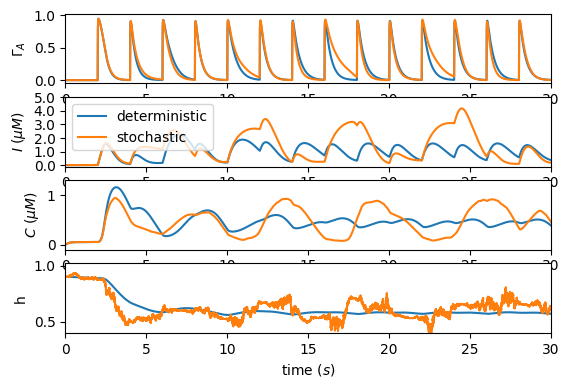

In [6]:
# Monitors
astro_mon = StateMonitor(astrocytes, variables=['Gamma_A', 'C', 'h', 'I'],
                         record=True)
run(duration, report='text')

# Plotting for Section 2.4
from matplotlib.ticker import FormatStrFormatter

# Plot Gamma_A
fig, ax = plt.subplots(4, 1, figsize=(6.26894, 6.26894*0.66))
ax[0].plot(astro_mon.t/second, astro_mon.Gamma_A.T)
ax[0].set(xlim=(0., duration/second), ylim=[-0.05, 1.02], yticks=[0.0, 0.5, 1.0],
          ylabel=r'$\Gamma_{A}$')

# Plot I
ax[1].plot(astro_mon.t/second, astro_mon.I.T/umolar)
ax[1].set(xlim=(0., duration/second), ylim=[-0.1, 5.0],
          yticks=arange(0.0, 5.1, 1., dtype=float),
          ylabel=r'$I$ ($\mu M$)')
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].legend(['deterministic', 'stochastic'], loc='upper left')

# Plot C
ax[2].plot(astro_mon.t/second, astro_mon.C.T/umolar)
ax[2].set(xlim=(0., duration/second), ylim=[-0.1, 1.3],
          ylabel=r'$C$ ($\mu M$)')

# Plot h
ax[3].plot(astro_mon.t/second, astro_mon.h.T)
ax[3].set(xlim=(0., duration/second),
          ylim=[0.4, 1.02],
          ylabel='h', xlabel='time ($s$)')

plt.show()